In [1]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.2.2
!pip install imbalanced-learn


Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
  Obtaining dependency information for scikit-learn==1.2.2 from https://files.pythonhosted.org/packages/2f/fd/9fcbe7fe94150e72d87120cbc462bde1971c3674e726b81f4a4c4fdfa8e1/scikit_learn-1.2.2-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Using cached scikit_learn-1.2.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-macosx_12_0_arm64.whl (8.4 MB)


In [2]:
import pickle
from sklearn.utils.extmath import randomized_svd
import scipy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import time

In [3]:
with open('x_train_final.pickle', 'rb') as handle:
    X_train_final = pickle.load(handle)
with open('x_test_final.pickle', 'rb') as handle:
    X_test_final = pickle.load(handle)

with open('y_train.pickle', 'rb') as handle:
    y_train = pickle.load(handle)
with open('y_test.pickle', 'rb') as handle:
    y_test = pickle.load(handle)

In [4]:

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler
ros = SMOTEENN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_final, y_train)

In [5]:
#Criar uma matriz esparsa pra otimizar tempo
#Utiliza-se o Singular Value Decomposition (SVD) para redução de dimensionalidade
# https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491

# o Randomized SVD é um modelo não otimizado porém com um bom desempenho do SVD, que utiliza aleatoriedade para buscar no espaço de soluções
# O método abaixo otimiza os parametros desse modelo e cria uma matriz final, truncada
# https://humaticlabs.com/blog/optimal-svht/


def gen_sparse_matrix(X_train_final, X_test_final):
    X_final_sparse = scipy.sparse.csr_matrix(np.vstack((X_train_final,X_test_final)))


    U, sigma, VT = randomized_svd(X_final_sparse, n_components=min(X_final_sparse.shape[0],X_final_sparse.shape[1])-1,n_iter=5,random_state=45)
    beta = min(X_final_sparse.shape) / max(X_final_sparse.shape)
    omega_approx = 0.56*beta**3 - 0.95*beta**2 + 1.82*beta + 1.43
    tau = np.median(sigma)*omega_approx
    k = np.max(np.where(sigma>tau))+1

    X_final_truncated = (U[:,:k]*sigma[:k])
    X_train_final_truncated = X_final_truncated[:X_train_final.shape[0],:]
    X_test_final_truncated = X_final_truncated[X_train_final.shape[0]:,:]
    
    return X_train_final_truncated, X_test_final_truncated


In [6]:
X_train_final_truncated,X_test_final_truncated = gen_sparse_matrix(X_train_final, X_test_final)

In [7]:
X_train_final_resampled, X_test_final_resampled = gen_sparse_matrix(X_resampled, X_test_final)

In [8]:
# #Salvando
with open('x_train_sparse.pickle', 'wb') as handle:
    pickle.dump(X_train_final, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('x_test_sparse.pickle', 'wb') as handle:
    pickle.dump(X_test_final, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:

# O Gaussian Naive-Bayes é uma adaptação do Naive Bayes para classificação, utilizando uma distribuição normal

time0 = time.time()
gnb = GaussianNB()
y_pred = gnb.fit(X_train_final_truncated, y_train).predict(X_test_final_truncated)
gnb1 = GaussianNB()
y_pred_resample = gnb1.fit(X_train_final_resampled, y_resampled).predict(X_test_final_resampled)
print(classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo']))
print(time.time()-time0)

              precision    recall  f1-score   support

    Negativo       0.52      0.87      0.65     15560
    Positivo       0.61      0.20      0.30     15559

    accuracy                           0.54     31119
   macro avg       0.56      0.54      0.48     31119
weighted avg       0.56      0.54      0.48     31119

0.22107291221618652


In [10]:
print(classification_report(y_test, y_pred_resample, target_names=['Negativo', 'Positivo']))

              precision    recall  f1-score   support

    Negativo       0.71      0.36      0.48     15560
    Positivo       0.57      0.85      0.68     15559

    accuracy                           0.61     31119
   macro avg       0.64      0.61      0.58     31119
weighted avg       0.64      0.61      0.58     31119



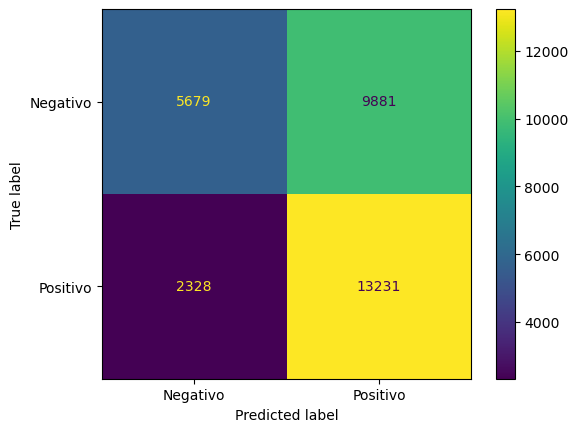

In [11]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_resample, display_labels=['Negativo', 'Positivo'])

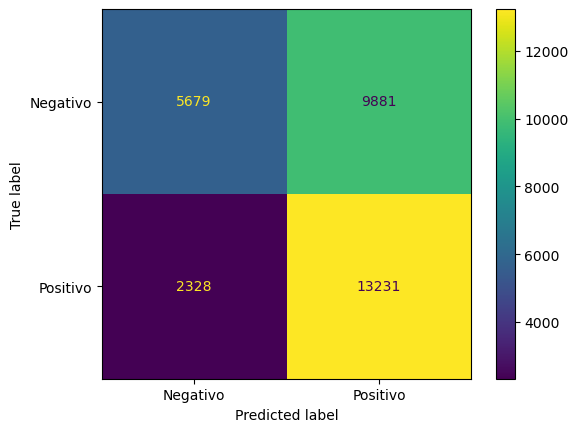

In [12]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_resample, display_labels=['Negativo', 'Positivo'])

In [20]:
# O Random Forest é um Ensemble (utiliza X árvores utilizando heuristicas específicas) que utiliza Arvores de Decisão
# Esses critérios podem ser Entropia ou Impureza (Gini), por exemplo
#https://www.ibm.com/topics/random-forest#:~:text=Random%20forest%20is%20a%20commonly,both%20classification%20and%20regression%20problems.

rf = RandomForestClassifier()

y_pred1 = rf.fit(X_train_final_truncated, y_train).predict(X_test_final_truncated)

# rf1 = RandomForestClassifier(random_state=0)
# y_pred_resample1 = rf1.fit(X_train_final_resampled, y_resampled).predict(X_test_final_resampled)



In [21]:
print(classification_report(y_test, y_pred1, target_names=['Negativo', 'Positivo']))

              precision    recall  f1-score   support

    Negativo       0.93      0.99      0.96     15560
    Positivo       0.99      0.93      0.96     15559

    accuracy                           0.96     31119
   macro avg       0.96      0.96      0.96     31119
weighted avg       0.96      0.96      0.96     31119



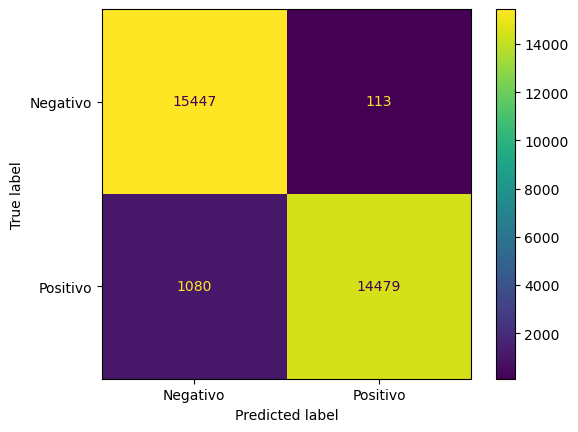

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred1, display_labels=['Negativo', 'Positivo'])

In [25]:
#O método de K vizinhos atribui a classificação a um novo exemplo de acordo com os K vizinhos (um vizinho é determinado pela proximidade baseado numa distancia, por exemplo euclidiana ou Manhattan)
# Por exemplo, com 3 vizinhos, o novo exemplo é classificado com a classe 0 se 2 ou mais vizinhos forem dessa classe
time0 = time.time()


neigh = KNeighborsClassifier(n_neighbors=3)
y_pred2 = neigh.fit(X_train_final_truncated, y_train).predict(X_test_final_truncated)

neigh1 = KNeighborsClassifier(n_neighbors=3)
y_pred_resample2 = neigh1.fit(X_train_final_resampled, y_resampled).predict(X_test_final_resampled)

print(time.time()-time0)


8.972644090652466


In [26]:
print(classification_report(y_test, y_pred2, target_names=['Negativo', 'Positivo']))

              precision    recall  f1-score   support

    Negativo       0.75      0.92      0.82     15560
    Positivo       0.90      0.69      0.78     15559

    accuracy                           0.80     31119
   macro avg       0.82      0.80      0.80     31119
weighted avg       0.82      0.80      0.80     31119



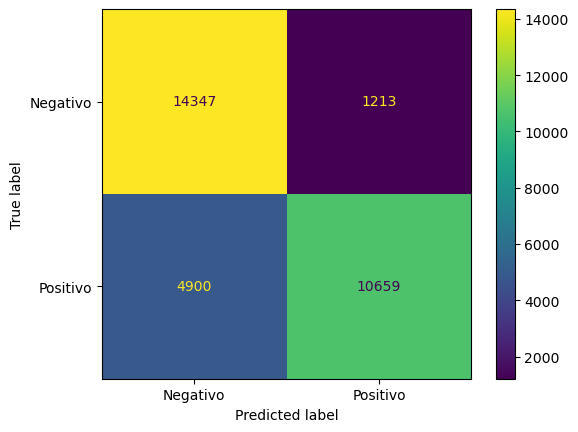

In [28]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred2, display_labels=['Negativo', 'Positivo'])

### Cross-Validation:

In [29]:
from sklearn.model_selection import cross_validate
X = np.concatenate((X_train_final_truncated, X_test_final_truncated))
y = np.concatenate((y_train, y_test))

In [38]:
scores = cross_validate(rf, X, y, cv=5, scoring='f1_macro')
scores

{'fit_time': array([117.80526996, 117.37848115, 116.37531996, 117.75060129,
        119.60161901]),
 'score_time': array([0.57455802, 0.55373383, 0.54613018, 0.56565475, 0.57751179]),
 'test_score': array([0.9514861 , 0.95457788, 0.95209896, 0.95164939, 0.96098104])}

In [37]:
scores = cross_validate(neigh, X, y, cv=5, scoring='f1_macro')
scores

{'fit_time': array([0.03514791, 0.02402091, 0.0206809 , 0.02093434, 0.02073288]),
 'score_time': array([5.49674916, 5.75938988, 6.02255797, 6.29614377, 6.2489543 ]),
 'test_score': array([0.79458896, 0.79458973, 0.79770974, 0.79054139, 0.80075713])}

In [36]:
scores = cross_validate(gnb, X, y, cv=5, scoring='f1_macro')
scores

{'fit_time': array([0.19559693, 0.09492612, 0.08942008, 0.0901351 , 0.09032607]),
 'score_time': array([0.02732611, 0.024266  , 0.02496195, 0.02484989, 0.02948713]),
 'test_score': array([0.46617503, 0.50253542, 0.47924113, 0.47697269, 0.47701659])}